# Module Dependency

In [22]:
import matplotlib.pyplot as plt 
import os
import sys
import torch
from model_test import PSPNet, PSPModule, PSPUpsample
import numpy as np
from skimage import io, measure
from torch.autograd import Variable
from torchvision import transforms

plt.rcParams['figure.figsize'] = (20.0, 16.0)

# Parameter Setting

In [16]:
width= 5000
high= 5000
edge_size= 512
crop_size= 512
confident_size= 400
USE_GPU = torch.cuda.is_available()
input_path= '/media/dennis/HDD/AerialImageDataset/train/images/'

# Function Definition 

## 1. Test Image Cropping

In [4]:
def crop(image, crop_size, confident_size):
    
    edge_size= 512
    
    high= image.shape[0]
    width= image.shape[1]
    depth= image.shape[2]
    assert(high, width)== (5000, 5000)
    
    atoll_size= (crop_size- confident_size)// 2
    crop_list= []
    
    for col in range(edge_size, width, edge_size):
        crop_list.append(image[0: edge_size, col- edge_size: col, :])
    crop_list.append(image[0: 0+ crop_size, -edge_size:, :])
    for row in range(edge_size* 2, high, edge_size):
        crop_list.append(image[row- edge_size: row, 0: edge_size, :])
        crop_list.append(image[row- edge_size: row, -edge_size:, :])
    for col in range(edge_size, width, edge_size):
        crop_list.append(image[-edge_size:, col- edge_size: col, :])
    crop_list.append(image[-edge_size:, -edge_size:, :])
    
    num_row= (high- 2* atoll_size)// confident_size
    num_col= (width- 2* atoll_size)// confident_size
    
    for row in range(num_row):
        for col in range(num_col):
            crop_list.append(image[row* confident_size: (row+ 1)* confident_size+ 2* atoll_size,
                                   col* confident_size: (col+ 1)* confident_size+ 2* atoll_size,
                                   :])
    return crop_list

## 2. Building Count

In [5]:
def count(image):
    
    high= image.shape[0]
    width= image.shape[1]
    counter= 0
    for row in range(high):
        for col in range(width):
            if image[row][col]:
                counter+= 1
                stack= []
                stack.append([row, col])
                while stack:
                    now_visit= stack.pop()
                    image[now_visit[0]][now_visit[1]]= 0
                    if now_visit[1]- 1>= 0 and image[now_visit[0]][now_visit[1]- 1]:
                        stack.append([now_visit[0], now_visit[1]- 1])
                    if now_visit[0]- 1>= 0 and image[now_visit[0]][now_visit[1]]:
                        stack.append([now_visit[0]- 1, now_visit[1]])
                    if now_visit[1]+ 1< width and image[now_visit[0]][now_visit[1]+ 1]:
                        stack.append([now_visit[0], now_visit[1]+ 1])
                    if now_visit[0]+ 1< high and image[now_visit[0]+ 1][now_visit[1]]:
                        stack.append([now_visit[0]+ 1, now_visit[1]])
    return counter

## 3. Numpy Array to Tensor

In [6]:
def toTensor(image):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image= transform(image)
    image= image.unsqueeze(0)
    return image

## 4. Combination

In [7]:
def combine(crop_list, crop_size, confident_size, high= 5000, width= 5000):
    
    edge_size= 512
    
    comb= np.empty([width, high])
    atoll_size= (crop_size- confident_size)// 2 
    count= 0

    for col in range(edge_size, width, edge_size):
        comb[0: edge_size, col- edge_size: col]= lbl_list[count]
        count+= 1
    comb[0: 0+ crop_size, -edge_size:]= lbl_list[count]
    count+= 1
    for row in range(edge_size* 2, high, edge_size):
        comb[row- edge_size: row, 0: edge_size]= lbl_list[count]
        comb[row- edge_size: row, -edge_size:]= lbl_list[count+ 1]
        count+= 2
    for col in range(edge_size, width, edge_size):
        comb[-edge_size:, col- edge_size: col]= lbl_list[count]
        count+= 1
    comb[-edge_size:, -edge_size:]= lbl_list[count]
    count+= 1

    for row in range(atoll_size+ confident_size, high, confident_size):
        for col in range(atoll_size+ confident_size, width, confident_size):
            comb[row- confident_size: row,
                 col- confident_size: col]= lbl_list[count][atoll_size: confident_size+ atoll_size, 
                                                            atoll_size: confident_size+ atoll_size]
            count+= 1

    return comb

# Forwarding

In [25]:
test_list= os.listdir(input_path)
test= io.imread(input_path+ 'chicago15.tif')
crop_list= crop(test, crop_size, confident_size)
lbl_list= []

# PSPNet= pspnet.PSPNet
# PSPModule= pspnet.PSPModule
# PSPUpsample= pspnet.PSPUpsample
model = torch.load('./model-1229-0.9549.pt')

count= 0
for image in crop_list:
    
    count+= 1
    print(count, end= ' ')
    test= toTensor(image)
    
    if USE_GPU:
        test= Variable(test.cuda())
    else:
        test= Variable(test)
        
    model.eval()
    output= model(test)
    output= transforms.ToPILImage()(output.data.cpu()[0])
    output= np.array(output)
    lbl_list.append(output)


# plt.imshow(crop_list[250])
# plt.show()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 

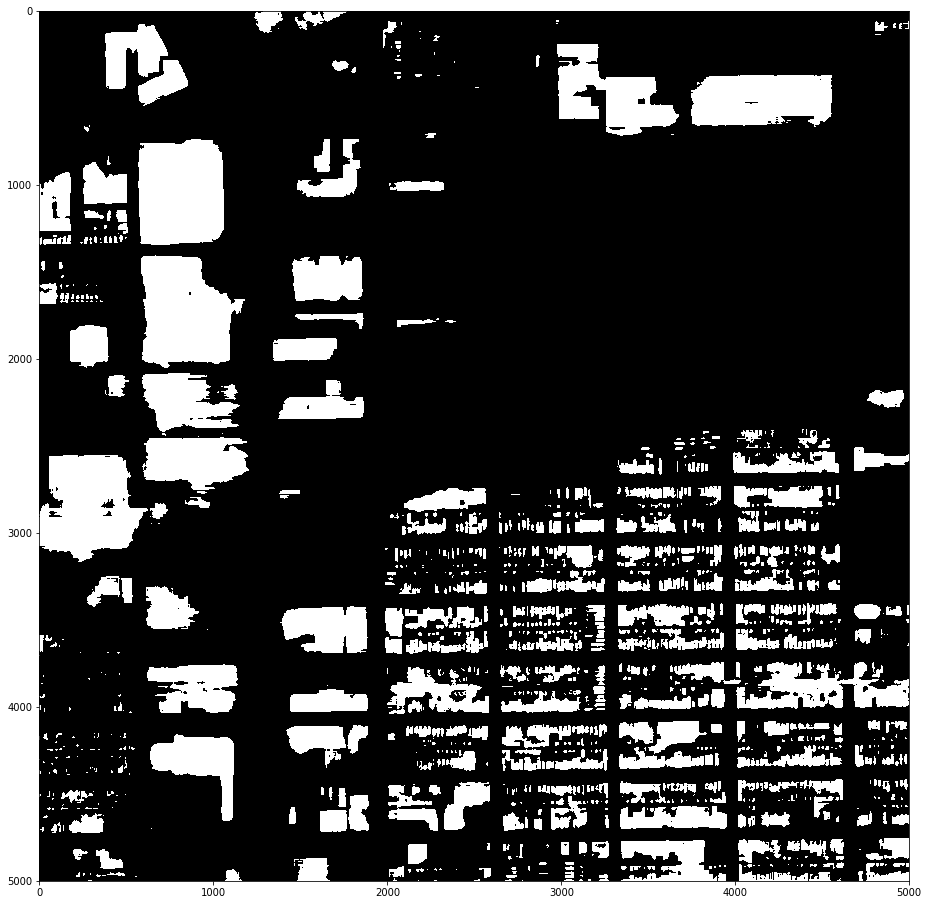

In [26]:
comb= combine(crop_list, crop_size, confident_size)
comb[comb>= 127]= 255
comb[comb< 127]= 0
#io.imsave('test.tif', comb.astype('uint8'))
plt.imshow(comb, cmap= 'gray')
plt.show()

In [27]:
test= comb.copy()
#test= io.imread('chicago14.tif')
counter, number = measure.label(test, return_num=True)         

print(number)

1248
